## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

## Generate data

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


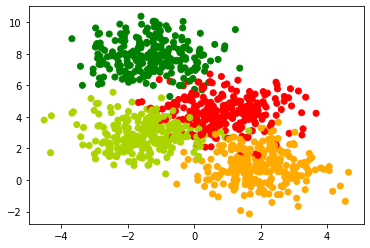

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

## Multi class classification

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [8]:

enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)# we are still working with the secondnetork.png

(750, 4) (250, 4)


## FF Class

In [9]:
class FFNetwork:
  
  # Including the activatoin function & the initialisation inside the init metod of the class
  # init_method = 'random' - means if not spefied then take a random initialisation method
  def __init__(self, init_method = 'random', activation_function = 'sigmoid', leaky_slope = 0.1):
        
    self.params={}
    self.params_h = []
    self.num_layers=2
    self.layer_sizes = [2, 2, 4]
    self.activation_function = activation_function
    self.leaky_slope = leaky_slope
    
    np.random.seed(0)
    
    # Having a buch of if conditions which has different Initilaisation methods
    if init_method == "random":
      for i in range(1,self.num_layers+1):
        # W and b are set to random numbers
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "he":
      for i in range(1,self.num_layers+1):
        # Same as Xavier just when taking a sqrt we are taking 2/incomming inputs
        self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(2/self.layer_sizes[i-1])
        self.params["B"+str(i)] = np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "xavier":
      for i in range(1,self.num_layers+1):
        # W has random numbers as we are doing in the random methods but 
        # in this case multiplying it by 1/sqrt of the incomming inputs
        # In layer-1 case 2 and layer2 case also 2 but id we would have taken a wider network then the value could have differed
        self.params["W"+str(i)]=np.random.randn(self.layer_sizes[i-1],self.layer_sizes[i])*np.sqrt(1/self.layer_sizes[i-1])
        # we do not divide the bias as we have only one bias term per neuron, so it is essentially like dividing by 1
        self.params["B"+str(i)]=np.random.randn(1,self.layer_sizes[i])
        
    elif init_method == "zeros":
      for i in range(1,self.num_layers+1):
        # All the values of W and b are set to 0's
        self.params["W"+str(i)]=np.zeros((self.layer_sizes[i-1],self.layer_sizes[i]))
        self.params["B"+str(i)]=np.zeros((1,self.layer_sizes[i]))
    
    self.gradients={}
    self.update_params={}
    self.prev_update_params={}
    for i in range(1,self.num_layers+1):
      self.update_params["v_w"+str(i)]=0
      self.update_params["v_b"+str(i)]=0
      self.update_params["m_b"+str(i)]=0
      self.update_params["m_w"+str(i)]=0
      self.prev_update_params["v_w"+str(i)]=0
      self.prev_update_params["v_b"+str(i)]=0
      
  # We have  2 broad activations forward activation for the forward pass and grad activation for the backward pass
  # For each of the case we have different types of activation functions
  # Can use this website to see the plots of the functoins - https://www.wolframalpha.com
  def forward_activation(self, X): 
    if self.activation_function == "sigmoid":
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == "tanh":
      return np.tanh(X)
    elif self.activation_function == "relu":
      return np.maximum(0,X)
    elif self.activation_function == "leaky_relu":
      # leaky_slope is defined in the __init__ so basically it takes the maximum of leakyslpoe*X and X
      # Therefore when X is positive it remais Y = X and when X is negetive insted of the value being 0 we have a small slope of 0.1
      return np.maximum(self.leaky_slope*X,X)
      
  def grad_activation(self, X):
    if self.activation_function == "sigmoid":
      return X*(1-X) 
    elif self.activation_function == "tanh":
      # This is the derivative of the activation functoin - tanh
      return (1-np.square(X))
    elif self.activation_function == "relu":
      # This is the derivative of the activation functoin - reku
      return 1.0*(X>0)
    elif self.activation_function == "leaky_relu":
      # This is the derivative of the activation functoin - leaky relu
      d=np.zeros_like(X)
      d[X<=0]=self.leaky_slope
      d[X>0]=1
      return d
  # The above functions will be approprietly calledint the gradient and forward pass

  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, axis=1).reshape(-1,1)
  
  def forward_pass(self, X, params = None):
    if params is None:
        params = self.params
    self.A1 = np.matmul(X, params["W1"]) + params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.softmax(self.A2) # (N, 4)
    return self.H2
  
  def grad(self, X, Y, params = None):
    if params is None:
      params = self.params 
      
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)
    
  def fit(self, X, Y, epochs=1, algo= "GD", display_loss=False, 
          eta=1, mini_batch_size=100, eps=1e-8,  
          beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
      
    if display_loss:
      loss = {}
      Y_pred = self.predict(X)
      loss[0] = log_loss(np.argmax(Y, axis=1), Y_pred)

    for num_epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      m = X.shape[0]
      
      if algo == "GD":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/m)
          
      elif algo == "MiniBatch":
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1,self.num_layers+1):
            self.params["W"+str(i)] -= eta * (self.gradients["dW"+str(i)]/mini_batch_size)
            self.params["B"+str(i)] -= eta * (self.gradients["dB"+str(i)]/mini_batch_size)
            
      elif algo == "Momentum":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
          self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]  
          
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif algo == "AdaGrad":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
          self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)])+eps)) * (self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)])+eps)) * (self.gradients["dB"+str(i)]/m)
      
      elif algo == "RMSProp":
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = beta*self.update_params["v_w"+str(i)] +(1-beta)*((self.gradients["dW"+str(i)]/m)**2)
          self.update_params["v_b"+str(i)] = beta*self.update_params["v_b"+str(i)] +(1-beta)*((self.gradients["dB"+str(i)]/m)**2)
          self.params["W"+str(i)] -= (eta/(np.sqrt(self.update_params["v_w"+str(i)]+eps)))*(self.gradients["dW"+str(i)]/m)
          self.params["B"+str(i)] -= (eta/(np.sqrt(self.update_params["v_b"+str(i)]+eps)))*(self.gradients["dB"+str(i)]/m)
      
      elif algo == "Adam":
        self.grad(X, Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)]/m)
          self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*((self.gradients["dW"+str(i)]/m)**2)
          m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
          v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["W"+str(i)] -=(eta/np.sqrt(v_w_hat+eps))*m_w_hat
          
          self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*(self.gradients["dB"+str(i)]/m)
          self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*((self.gradients["dB"+str(i)]/m)**2)
          m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
          v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
          self.params["B"+str(i)] -=(eta/np.sqrt(v_b_hat+eps))*m_b_hat
          
      if display_loss:
        Y_pred = self.predict(X)
        # At the end of each epoch we are logging the loss value
        loss[num_epoch+1] = log_loss(np.argmax(Y, axis=1), Y_pred)
        # At every epoch we are appending all the parameters on our network onto it
        # So we are taking all the parametes and concatinating them and hence we get a 1,18 numpy array which is appended as self.params_h
        # ravel - Converts a N-Dimentional array into a 1D array
        self.params_h.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel())))
    
    if display_loss:
      plt.plot(loss.values(), '-o', markersize=5)
      plt.xlabel('Epochs')
      plt.ylabel('Log Loss')
      plt.show()
      
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

In [10]:

# We have to first initialise the model we would fit the model and then we would call post processing
# It first of all computes the Traning and Validatoin accuracy
# plot_scale this means that the ylim in line 32 are -0.1 to 0.1
def post_process(scatter_plot=False, gradient_plot=True, plot_scale=0.1):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))    
    
    # Plotting the scattered plot, wehre we were plotting the input data points and 
    # showing them by different sizes to denote weather the algo is actually able to classify them corrctly or not
    if scatter_plot:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()
    
    # This is the thing tha we have added new - The idea is to be able to look at these 18 parametes and plot the changes in each of these parameters in each epoch
    if gradient_plot:
      #Converting it into a numpy array
      h = np.asarray(model.params_h)
      # It finds the update that each paramenter is making - It will do a point wise sub. 0 fomr 1, 1 from 2 and so on for each coulmn
      h_diff = (h[0:-1, :] - h[1:, :])
      # Creating multiple subplots - in 6 rows and 3 column, after which we have to give an index here starting from one - i+1
      for i in range(18):
        plt.subplot(6, 3, i+1)
        plt.plot(h_diff[:, i], '-')
        # standard plotting
        plt.ylim((-plot_scale, plot_scale))
        # Removing xticks and yticks - we are keeping this empty list so that we can have small plots where we can quickly see inside 
        plt.yticks([])
        plt.xticks([])
      plt.show()

  0%|          | 0/10 [00:00<?, ?epoch/s]

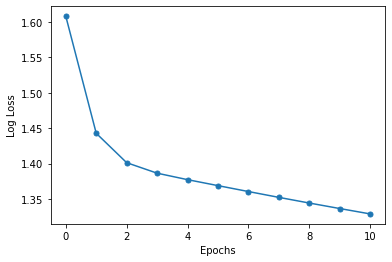

Training accuracy 0.376
Validation accuracy 0.384


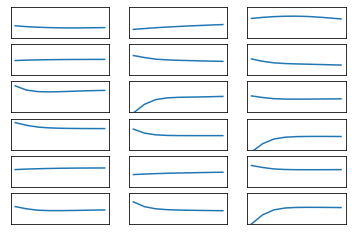

In [11]:

# Xavier with sigmoid
model = FFNetwork(init_method='xavier', activation_function='sigmoid')
model.fit(X_train, y_OH_train, epochs=10, eta=1, algo="GD", display_loss=True)
post_process()
# Only for 10 epochs, the loss is falling.# 
# For the smaller plots anything close to middle is close to zero gradients.
# Last 6 plots are bias plots and the next four are the weight correponding to the 1st layer and the next 8 are the weight corresponding to the second layer  

Process  
now what we will do is go throught each of the activation functions one by one and look at all init methods and see what we can learn from them.

zeros sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

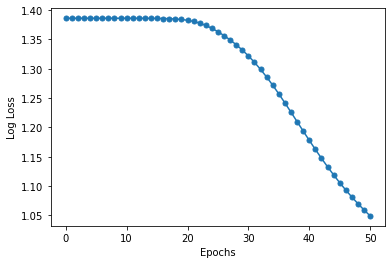

Training accuracy 0.528
Validation accuracy 0.54


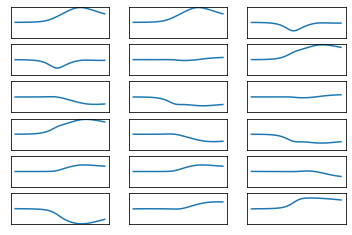


--

random sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

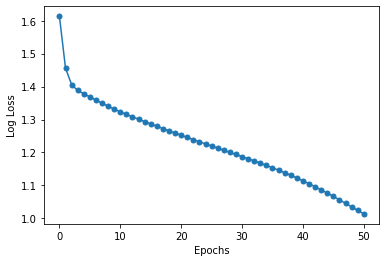

Training accuracy 0.5827
Validation accuracy 0.568


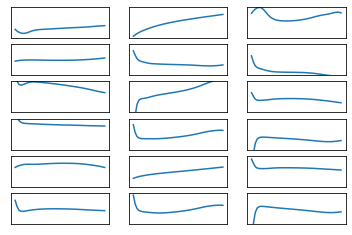


--

xavier sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

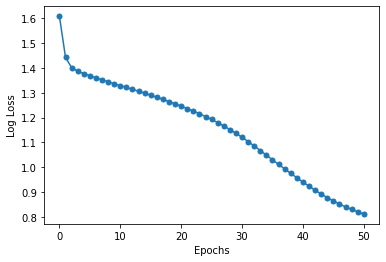

Training accuracy 0.8747
Validation accuracy 0.88


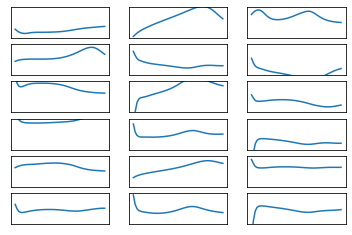


--

he sigmoid


  0%|          | 0/50 [00:00<?, ?epoch/s]

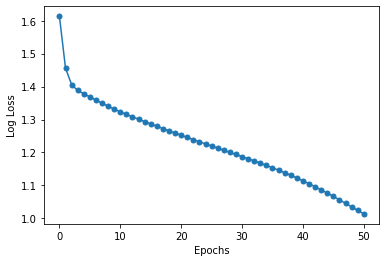

Training accuracy 0.5827
Validation accuracy 0.568


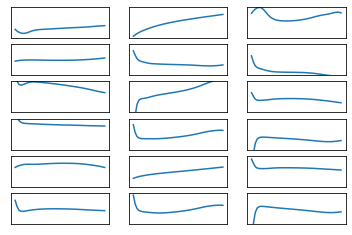


--



In [12]:
# Ideally we would have for, for both initilisation methods and activation functions and see which one makes sense.
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['sigmoid']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=50, eta=1, algo="GD", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

__Observation for Sigmoid__  
maximum value possible for a sigmoid gradient is 0.25  

* __Zeros:__   
Very Low accuracy, the log loss is falling vey slowely.
The main thing we can observe is in the small plots that the symmety breaking does not happen. The first two plots are W1   and W2 annd they look exactly the same. So, if we start the initialsation with zero the weight whcih are associated with  the same neuron cannot have different values. (If we look into the small plots carefully we would be able to find pairs of  similar plots.). It is okay to have Biases as 0 as the weight can be different and that can lead to asymmetry or symmetry  breaking, but it is a very bad idea to take all the weights to zeros.


* __Random:__
The loss plot is decreasing slightly further, one thing is clearly visable that there are more visible trends on the update plots. No such symmety anymore, some ore foing to very large value. One of the reasons we do not use this is beacuse there can ve gradient explosions because the value assigned by random can be a very large value  


* __Xavier:__  
It is the suggested method for sigmoid functions. It is getting to a very very high accuracy. It is the highest we are getting. Keeping the same everthing we just changed the initialistoin method and many things improved. The difference between random and xavier is that we have divided by the sqrt of 2 (no. of neurons in each of the cases). It is this way because, we need to ensure that we are in the middle port part of the derivative of sigmoid, where the gradients are not zero. This alone ends up leading to a much smoother decrease in the log loss and hence much higher accuracy.


* __He:__  
In this case we are multiplying by sqrt of 2 in the numerator of the weight assignments we can see that the accuracy is again significantly low. It is interesting to see that a small ratio can play such an important role in the accuracy we see.


zeros tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

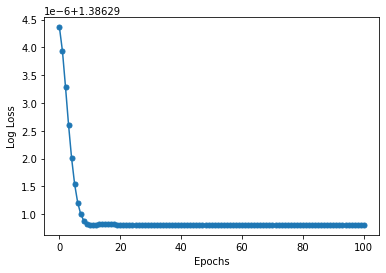

Training accuracy 0.2507
Validation accuracy 0.248


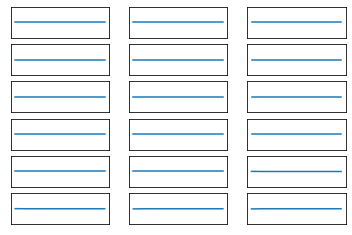


--

random tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

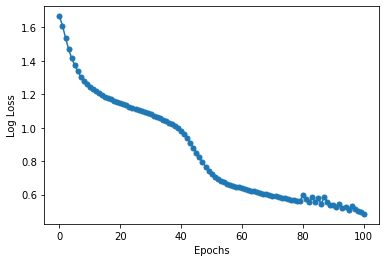

Training accuracy 0.8547
Validation accuracy 0.86


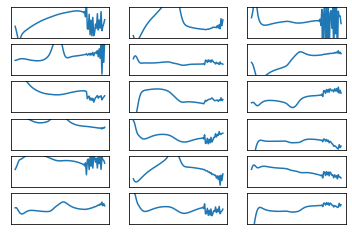


--

xavier tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

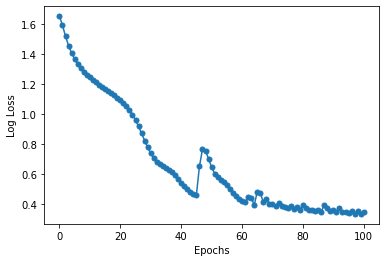

Training accuracy 0.88
Validation accuracy 0.88


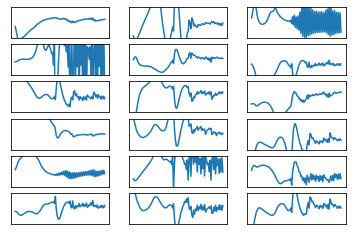


--

he tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

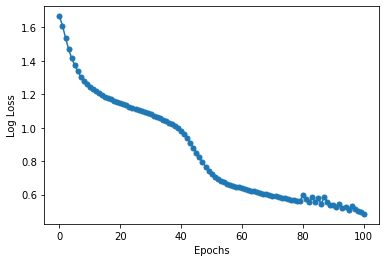

Training accuracy 0.8547
Validation accuracy 0.86


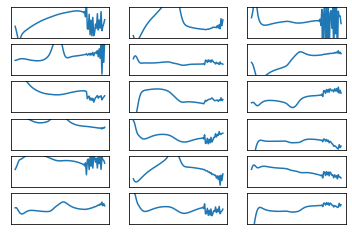


--



In [13]:
# Everything remains the same all we are changing is the activation function.
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['tanh']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=100, eta=0.5, algo="NAG", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

__Observation for tanh__  
The max derivative of tanh is 1.  
* __Zeros:__  
When we see the plots it is clearly visible that the  plots are more or less all close to 0. As we can see the log plot also the Y axis has very close numbers. So in case of sigmoid it was learning atleast something but in this case it is more or less nearning nothing, this is because. In case of sigmoid, the value at 0 is 0.5 whereas in the case of tanh the value at zero is 0. So in case of tanh the first layer output when the vaues are zero the second layer isnot able to work with anything. So at zeros tanh activatoin function dies not learn anything.


* __Random:__  
In random they do learn, we can see that the gradients are a bit larger, they grow very quickly  if in the regions where gradient is close to 1 then the plots are going out of sscale, the performence is better than the sigmoid one but not the best we have see so far.


* __Xavier:__  
When we use this activavtion function, this is the recommended activation for tanh, we get a higher accuracy but there is a bit of oossilatoin here, we can see in the log loss plot that the accuracy at a previous plot is much better than the accuracy we got finally. We should typically use a smaller learning rate in these cases. In the update plots we can see a lot more activity happening, this is beacuse we have larger gradients in tanh. So the recommended thing during ossilation of plots when using Xavier in tanh we can decrease the learning rate and increse the no. of epochs a little.(If we half the learning rate we should double the numver of epochs.)

* __He:__  
He is more or less doing the same thing as Xavier but stil the recommended activation for tanh is Xavier which is doing significantly better.

zeros relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

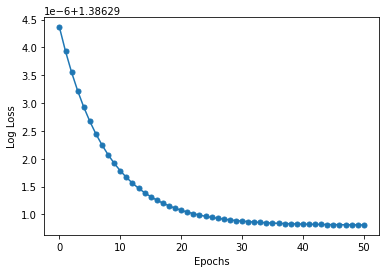

Training accuracy 0.2507
Validation accuracy 0.248


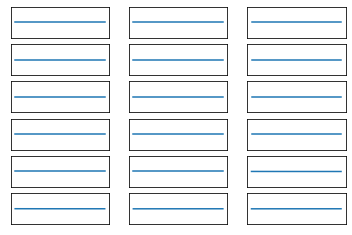


--

random relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

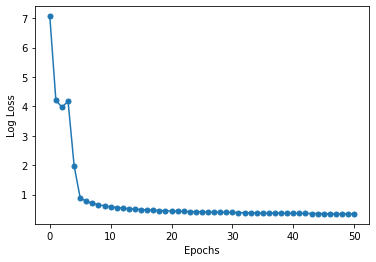

Training accuracy 0.9067
Validation accuracy 0.92


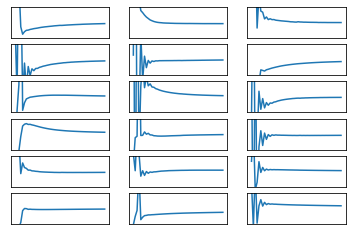


--

xavier relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

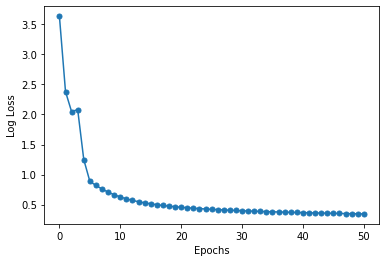

Training accuracy 0.9053
Validation accuracy 0.924


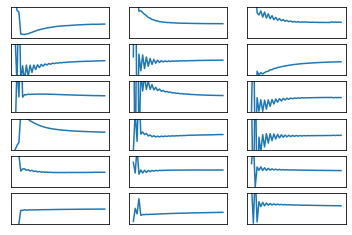


--

he relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

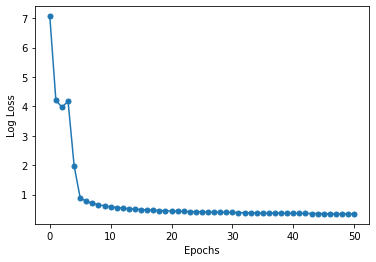

Training accuracy 0.9067
Validation accuracy 0.92


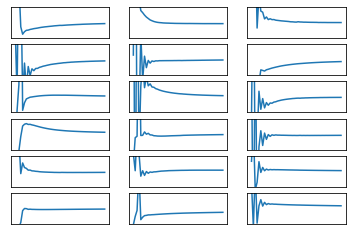


--



In [14]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['relu']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, y_OH_train, epochs=50, eta=0.25, algo="GD", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

__Observation for relu__  
1.  
* __Zeros:__  
It does not work same as in case of tanh. We have explicitely defined that at 0 relu is 0. Hence we are prpagating zeros throught and there is nothing to learn.

* __Random:__  
In random it is giving a very poor accuray and it is not learning much, what seems to be happening in the very beggening it made a very bad choice.(It goes upto 16). So in general it is good to have smaller learning rates with relu functions. By just changeing the learning rate making it small can significantly improve the accuracy


* __Xavier:__  
It is not learning with xavier also, it is haveing a very bad accuracy, it is ossilating b/w high and low values. By just changeing the learning rate making it small can significantly improve the accuracy

* __He:__  
He is more or less same as the random ones so onthing mucg to say


zeros leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

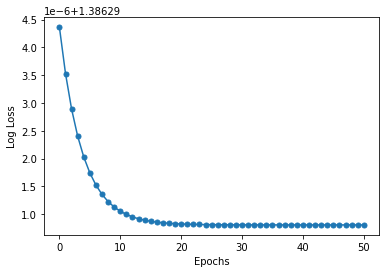

Training accuracy 0.2507
Validation accuracy 0.248


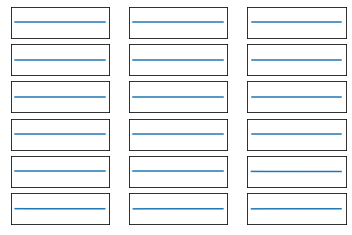


--

random leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

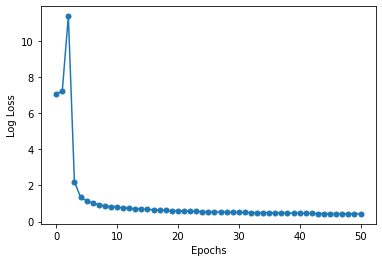

Training accuracy 0.8933
Validation accuracy 0.9


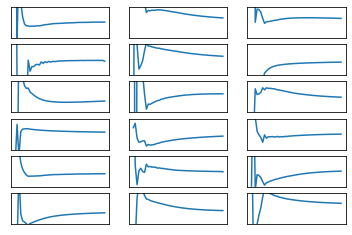


--

xavier leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

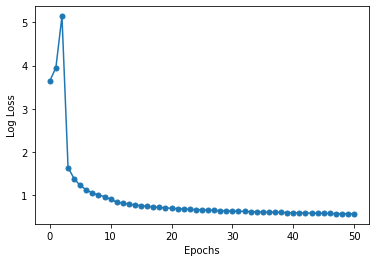

Training accuracy 0.8027
Validation accuracy 0.812


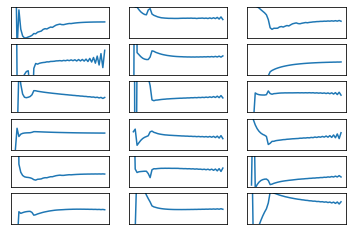


--

he leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

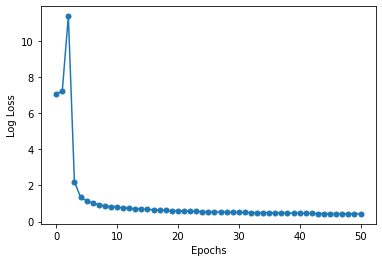

Training accuracy 0.8933
Validation accuracy 0.9


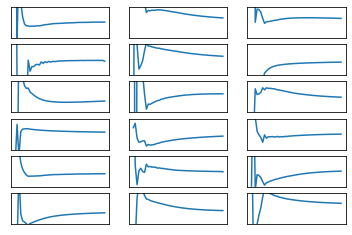


--



In [15]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['leaky_relu']:
    print(init_method, activation_function)
    model = FFNetwork(init_method=init_method, activation_function=activation_function, leaky_slope=0.1)
    model.fit(X_train, y_OH_train, epochs=50, eta=0.5, algo="GD", display_loss=True)
    post_process(plot_scale=0.05)
    print('\n--\n')

__Observation for leaky relu__  
Leaky relu is ensureing high accuracy as it is giveing non 0 gradients all the time
* __Zeros:__  
The value at zero is zero so no learning is happening

* __Random:__  
It is comming to a fairly large accuracy bit there is a lot of ossilation happening, also visible in the update plots


* __Xavier:__  
In this case we are not getting into that high of an accuracy, for relu and laeky relu we should always use the he initialisation.

* __He:__  
We should be learning smaller learning rates here.

## Exercises

1. Try out different combinations of learning_algorithm, initialisation method, and activation_function
2. Try a deeper network - eg. [2, 2, 2, 4] 
3. Try a different dataset, i.e. different set of blobs